<a href="https://colab.research.google.com/github/myidispg/deep_learning_specialization/blob/master/CNN/Week%202/PyTorch_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

data_dir = './data'

In [2]:
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root=data_dir, train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root=data_dir, train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

0it [00:00, ?it/s]

170500096it [00:04, 39297733.79it/s]                               


Files already downloaded and verified


# Plotting some images from both the train and test set

Plotting 10 random images from the train set and their corresponding labels...


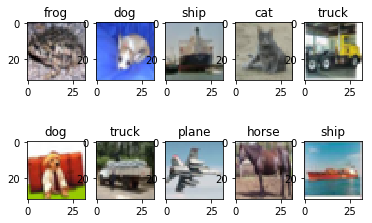

In [3]:
# To unnormalize the image and put channel after the image height and width.
def im_show_process(img):
  img = (img / 2) + 0.5 # Unnormalize the image
  img = img.numpy()
  # Since, PyTorch needs channels before the height and width and
  # matplotlib needs channels afterwards, transpose them to make images compatible.
  return np.transpose(img, (1, 2, 0))

print(f'Plotting 10 random images from the train set and their corresponding labels...')
dataiter = iter(trainloader)
images, labels = dataiter.next()

f, axarr = plt.subplots(2, 5)

for i in range(2):
  for j in range(5):
    index = np.random.randint(0, 64)
    axarr[i, j].imshow(im_show_process(images[index]))
    axarr[i, j].set_title(classes[labels[index]])

Plotting 10 random images from the test set and their corresponding labels...


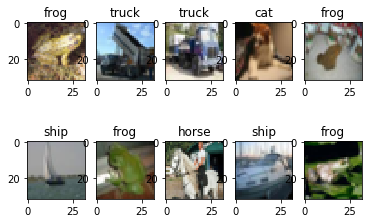

In [4]:
print(f'Plotting 10 random images from the test set and their corresponding labels...')
dataiter = iter(testloader)
images, labels = dataiter.next()

f, axarr = plt.subplots(2, 5)

for i in range(2):
  for j in range(5):
    index = np.random.randint(0, 64)
    axarr[i, j].imshow(im_show_process(images[index]))
    axarr[i, j].set_title(classes[labels[index]])

# Thanks to PyTorch datasets, not much of anything is required.
# Next step: Building the model.

In [72]:
def identity_block(X, f, filters, in_channels):
  """
  Implementing an identity block where the dimensions of both the 
  operands to be added are same.
  
  Inputs:
  X: Input tensor of shape(m, n_channels, n_H, n_W)
  f: filter size for the middle convolutional layer of the main path.
  filters: A list of 3 integers specifying the number of filters at each layer
           in the main path.
  in_channels = Number of input channels
  
  Output: Output of the identity block of shape(n_channels, n_H, n_W)
  """
  
  # Retrieve the filters
  F1, F2, F3 = filters
  
  # The input value will be needed later for the skip connection.
  X_shortcut = X
  
  # First layer of the main path
  X = Conv2D(in_features, F1, kernel_size=(1,1), strides=(1,1))
  
  
import torch.nn as nn
import torch.nn.functional as F


class IdentityBlock(nn.Module):
  
  def __init__(self, f, filters, in_channels):
    super(IdentityBlock, self).__init__()
    
    F1, F2, F3 = filters
    
    # First component in the main path
    self.conv1 = nn.Conv2d(in_channels, F1, kernel_size=(1,1), stride=(1,1))
    self.batch_norm1 = nn.BatchNorm2d(F1)
    
    # Second component in the main path
    # Since PyTorch does not implement valid padding and same padding,
    # manually apply padding to cover case of both even and odd filter size.
    pad = (f-1)/2
    self.conv2 = None
    if f%2 == 0: # If the filter size is even, padding only the right side.
      limit = f-1
      pad_1 = (f-1)//2
      pad_2 = limit-pad_1
      self.is_zero_pad = True
      self.zero_pad = nn.ZeroPad2d((pad_1, pad_2, pad_1, pad_2))
      self.conv2 = nn.Conv2d(F1, F2, kernel_size=(f,f), stride=(1,1), padding=0)
    else:
      self.conv2 = nn.Conv2d(F1, F2, kernel_size=(f,f), stride=(1,1), padding=pad)
    self.batch_norm2 = nn.BatchNorm2d(F2)
    # Third component in the main path
    self.conv3 = nn.Conv2d(F2, F3, kernel_size=(1,1), stride=(1,1))
    self.batch_norm3 = nn.BatchNorm2d(F3)
    
    self.relu = nn.ReLU()
    
  def layer(self, X):
    X_shortcut = X
#     print(f'Shape of shortcut: {X.shape}')
    
    X = self.relu(self.batch_norm1(self.conv1(X)))
#     print(f'After 1: {X.shape}')
#     print(f'SHape zero pad: {self.zero_pad(X).shape}')
    if self.is_zero_pad:
      X = self.relu(self.batch_norm2(self.conv2(self.zero_pad(X))))
    else:
      X = self.relu(self.batch_norm2(self.conv2(X)))
#     print(f'After 2: {X.shape}')
    X = self.batch_norm3(self.conv3(X))
#     print(f'After 3: {X.shape}')
    X = torch.add(input = X, other=X_shortcut)
    return self.relu(X)
    
    
test = IdentityBlock(6, [2,4,6], 6)
image = torch.randn((3, 6, 64, 64))
image = test.layer(image)
print(image.shape)


torch.Size([3, 6, 64, 64])
